In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd






def add_noise(image, noise_type="salt_and_pepper", noise_level=0.1):
    noisy_image = image.copy()
    if noise_type == "salt_and_pepper":
        num_pixels = int(noise_level * image.size)
        indices = np.random.choice(image.size, num_pixels, replace=False)
        flat_image = noisy_image.flatten()
        flat_image[indices] = -flat_image[indices]
        noisy_image = flat_image.reshape(image.shape)
    elif noise_type == "gaussian":
        noisy_image = image + np.random.normal(0, noise_level, image.shape)
        noisy_image = np.where(noisy_image > 0, 1, -1)  # Threshold to binary
    return noisy_image

def compute_nmse(ground_truth, denoised_image):
    return np.linalg.norm(denoised_image - ground_truth)**2 / np.linalg.norm(ground_truth)**2

def gibbs_sampling(noisy_img, h, beta, eta, iterations=None):
    rows, cols = noisy_img.shape
    denoised_img = noisy_img.copy()

    if iterations is None:
        iterations = 1000
    for _ in range(iterations):
        old_img = denoised_img.copy()
        for i in range(rows):
            for j in range(cols):
                neighbors = []
                if i > 0: neighbors.append(denoised_img[i-1, j])
                if i < rows-1: neighbors.append(denoised_img[i+1, j])
                if j > 0: neighbors.append(denoised_img[i, j-1])
                if j < cols-1: neighbors.append(denoised_img[i, j+1])
                neighbors_sum = sum(neighbors)
                
                energy_plus = h + beta * neighbors_sum + eta * noisy_img[i, j]
                energy_minus = -h - beta * neighbors_sum - eta * noisy_img[i, j]
                
                prob_plus = np.exp(energy_plus)
                prob_minus = np.exp(energy_minus)
                prob = prob_plus / (prob_plus + prob_minus)
                
                # Sample new state
                denoised_img[i, j] = 1 if np.random.rand() < prob else -1

        if np.array_equal(denoised_img, old_img):            
            print("Converged")
            return denoised_img
    return denoised_img

# Mean Field Approximation Implementation
def mean_field_approximation(noisy_img, h, beta, eta, iterations, damping=0.8):
    rows, cols = noisy_img.shape
    mu = noisy_img.copy().astype(float)
    for _ in range(iterations):
        for i in range(rows):
            for j in range(cols):
                neighbors = []
                if i > 0: neighbors.append(mu[i-1, j])
                if i < rows-1: neighbors.append(mu[i+1, j])
                if j > 0: neighbors.append(mu[i, j-1])
                if j < cols-1: neighbors.append(mu[i, j+1])
                neighbors_sum = sum(neighbors)
                
                ai = beta * neighbors_sum + 0.5 * eta * noisy_img[i, j]
                new_mu = np.tanh(ai)
                mu[i, j] = (1 - damping) * mu[i, j] + damping * new_mu
    return np.sign(mu)



In [34]:
letterA = pd.read_csv('letterA.csv').to_numpy()
rows, cols = letterA.shape
letterA = np.where(letterA > 0.5, 1, -1)  # Convert to binary states

Q1

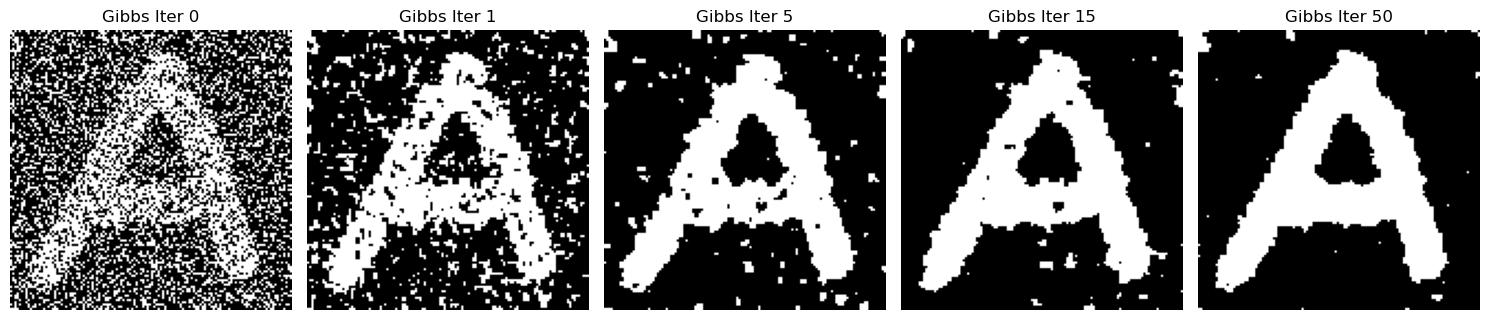

In [38]:
import matplotlib.pyplot as plt

original_image = letterA
iterations = [0, 1, 5, 15, 50]
noise_level = 0.3
h = 0.1  
beta = 1
eta = 1

noisy_image = add_noise(original_image, noise_type="salt_and_pepper", noise_level=noise_level)
fig, axes = plt.subplots(1, len(iterations) , figsize=(15, 6))
for i, iteration in enumerate(iterations):
    denoised_gibbs = gibbs_sampling(noisy_image, h, beta, eta, iteration)
    axes[ i ].imshow(denoised_gibbs, cmap='gray')
    axes[ i ].set_title(f'Gibbs Iter {iteration}')
    axes[i ].axis('off')

plt.tight_layout()
plt.show()

Q2

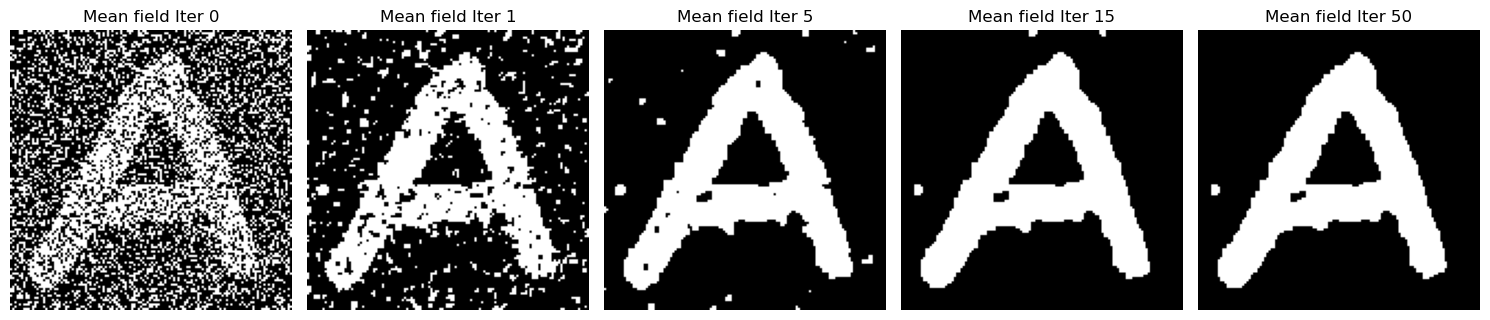

In [39]:
import matplotlib.pyplot as plt

original_image = letterA
iterations = [0, 1, 5, 15, 50]
noise_level = 0.3
h = 0.1  
beta = 1
eta = 1

noisy_image = add_noise(original_image, noise_type="salt_and_pepper", noise_level=noise_level)
fig, axes = plt.subplots(1, len(iterations) , figsize=(15, 6))
for i, iteration in enumerate(iterations):
    denoised_meanfield = mean_field_approximation(noisy_image, h, beta, eta, iteration)
    axes[ i ].imshow(denoised_meanfield, cmap='gray')
    axes[ i ].set_title(f'Mean field Iter {iteration}')
    axes[i ].axis('off')

plt.tight_layout()
plt.show()

Q3

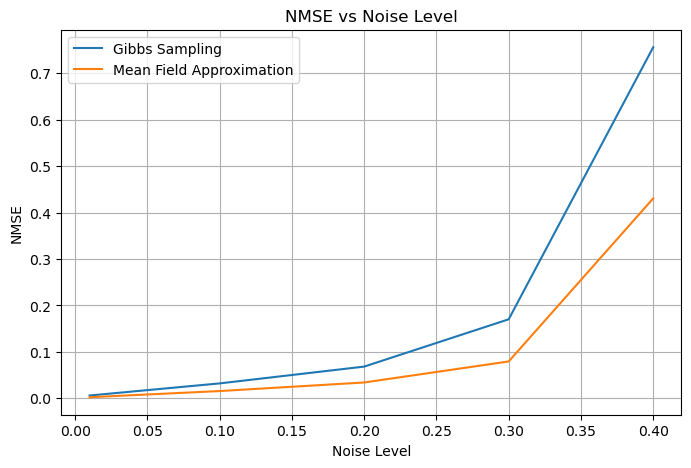

In [40]:
noise_levels = [0.01, 0.1, 0.2, 0.3,0.4]
nmse_results_gibbs = []
nmse_results_mf = []
iterations = 50


for noise_level in noise_levels:
    noisy_image = add_noise(letterA, noise_type="salt_and_pepper", noise_level=noise_level)
    denoised_gibbs = gibbs_sampling(noisy_image, h, 1.0, 1.5, iterations)
    denoised_mf = mean_field_approximation(noisy_image, h, 1.0, 1.5, iterations)
    nmse_results_gibbs.append(compute_nmse(letterA, denoised_gibbs))
    nmse_results_mf.append(compute_nmse(letterA, denoised_mf))

# Plot NMSE vs Noise Level
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, nmse_results_gibbs, label="Gibbs Sampling")
plt.plot(noise_levels, nmse_results_mf, label="Mean Field Approximation")
plt.xlabel("Noise Level")
plt.ylabel("NMSE")
plt.title("NMSE vs Noise Level")
plt.legend()
plt.grid()
plt.show()



Q4

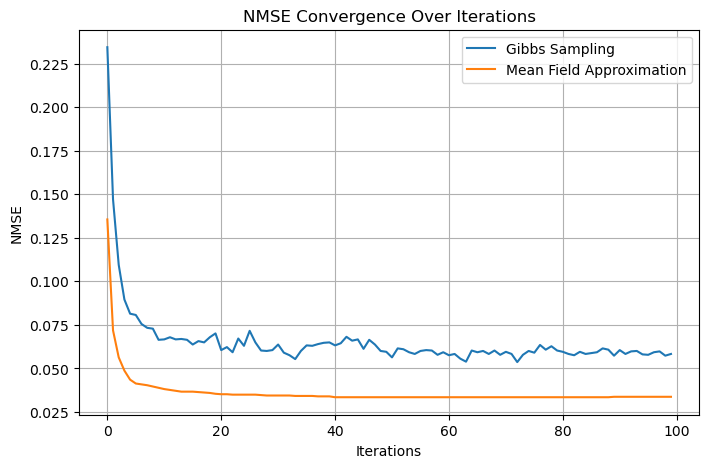

Final NMSE (Gibbs Sampling): 0.0583
Final NMSE (Mean Field Approximation): 0.0337


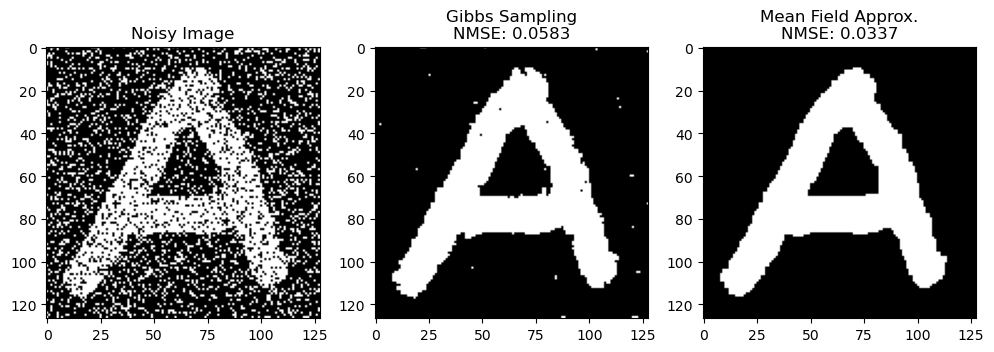

In [45]:
#solutin to Q4 
# Track NMSE over iterations
def track_nmse_over_iterations(noisy_img, ground_truth, h, beta, eta, iterations):
    nmse_gibbs = []
    nmse_mf = []

    # Initialize Gibbs Sampling and Mean Field Approximation
    denoised_img_gibbs = noisy_img.copy()
    mu = noisy_img.copy().astype(float)

    for it in range(iterations):
        # Gibbs Sampling
        for i in range(rows):
            for j in range(cols):
                neighbors = []
                if i > 0: neighbors.append(denoised_img_gibbs[i-1, j])
                if i < rows-1: neighbors.append(denoised_img_gibbs[i+1, j])
                if j > 0: neighbors.append(denoised_img_gibbs[i, j-1])
                if j < cols-1: neighbors.append(denoised_img_gibbs[i, j+1])
                neighbors_sum = sum(neighbors)

                energy_plus = h + beta * neighbors_sum + eta * noisy_img[i, j]
                energy_minus = -h - beta * neighbors_sum - eta * noisy_img[i, j]

                prob_plus = np.exp(energy_plus)
                prob_minus = np.exp(energy_minus)
                prob = prob_plus / (prob_plus + prob_minus)

                denoised_img_gibbs[i, j] = 1 if np.random.rand() < prob else -1

        nmse_gibbs.append(compute_nmse(ground_truth, denoised_img_gibbs))

        # Mean Field Approximation
        for i in range(rows):
            for j in range(cols):
                neighbors = []
                if i > 0: neighbors.append(mu[i-1, j])
                if i < rows-1: neighbors.append(mu[i+1, j])
                if j > 0: neighbors.append(mu[i, j-1])
                if j < cols-1: neighbors.append(mu[i, j+1])
                neighbors_sum = sum(neighbors)

                ai = beta * neighbors_sum + 0.5 * eta * noisy_img[i, j]
                new_mu = np.tanh(ai)
                mu[i, j] = (1 - 0.8) * mu[i, j] + 0.8 * new_mu

        nmse_mf.append(compute_nmse(ground_truth, np.sign(mu)))

    return nmse_gibbs, nmse_mf

# Run comparison
noisy_image = add_noise(letterA, noise_type="salt_and_pepper", noise_level=0.2)
iterations = 100

h=0
nmse_gibbs, nmse_mf = track_nmse_over_iterations(noisy_image, letterA, h, 1.0, 1.5, iterations)

# Plot NMSE over iterations
plt.figure(figsize=(8, 5))
plt.plot(range(iterations), nmse_gibbs, label="Gibbs Sampling")
plt.plot(range(iterations), nmse_mf, label="Mean Field Approximation")
plt.xlabel("Iterations")
plt.ylabel("NMSE")
plt.title("NMSE Convergence Over Iterations")
plt.legend()
plt.grid()
plt.show()

# Final Results
final_nmse_gibbs = nmse_gibbs[-1]
final_nmse_mf = nmse_mf[-1]

print(f"Final NMSE (Gibbs Sampling): {final_nmse_gibbs:.4f}")
print(f"Final NMSE (Mean Field Approximation): {final_nmse_mf:.4f}")

# Visual comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title("Noisy Image")

plt.subplot(1, 3, 2)
plt.imshow(gibbs_sampling(noisy_image, h, 1.0, 1.5, iterations), cmap='gray')
plt.title(f"Gibbs Sampling\nNMSE: {final_nmse_gibbs:.4f}")

plt.subplot(1, 3, 3)
plt.imshow(mean_field_approximation(noisy_image, h, 1.0, 1.5, iterations), cmap='gray')
plt.title(f"Mean Field Approx.\nNMSE: {final_nmse_mf:.4f}")

plt.show()


Q5

In [41]:
# Parameter Sensitivity Analysis
beta_values = [0.5, 1.0, 1.5]  
eta_values = [1.0, 1.5, 2.0]  
for beta in beta_values:
    for eta in eta_values:
        noisy_image = add_noise(letterA, noise_type="salt_and_pepper", noise_level=0.2)
        denoised_gibbs = gibbs_sampling(noisy_image, h, beta, eta, iterations)
        nmse_gibbs = compute_nmse(letterA, denoised_gibbs)
        print(f"Beta: {beta}, Eta: {eta}, NMSE (Gibbs): {nmse_gibbs:.4f}")

Beta: 0.5, Eta: 1.0, NMSE (Gibbs): 0.3110
Beta: 0.5, Eta: 1.5, NMSE (Gibbs): 0.4865
Beta: 0.5, Eta: 2.0, NMSE (Gibbs): 0.6297
Beta: 1.0, Eta: 1.0, NMSE (Gibbs): 0.0568
Beta: 1.0, Eta: 1.5, NMSE (Gibbs): 0.0659
Beta: 1.0, Eta: 2.0, NMSE (Gibbs): 0.1371
Beta: 1.5, Eta: 1.0, NMSE (Gibbs): 0.0490
Beta: 1.5, Eta: 1.5, NMSE (Gibbs): 0.0384
Beta: 1.5, Eta: 2.0, NMSE (Gibbs): 0.0517


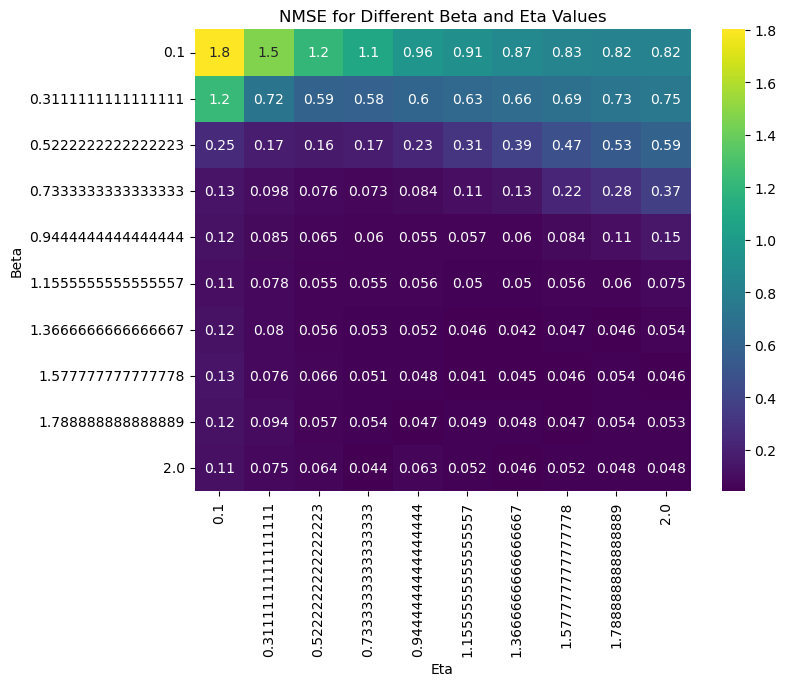

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameter Sensitivity Analysis
beta_values = np.linspace(0.1, 2, 10).tolist()  
eta_values =  np.linspace(0.1, 2, 10).tolist() 
nmse_values = np.zeros((len(beta_values), len(eta_values)))
noisy_image = add_noise(letterA, noise_type="salt_and_pepper", noise_level=0.2)
iterations = 20
for i, beta in enumerate(beta_values):
    for j, eta in enumerate(eta_values):
        denoised_gibbs = gibbs_sampling(noisy_image, h, beta, eta, iterations)
        nmse_gibbs = compute_nmse(letterA, denoised_gibbs)
        nmse_values[i, j] = nmse_gibbs

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(nmse_values, annot=True, xticklabels=eta_values, yticklabels=beta_values, cmap="viridis")
plt.xlabel('Eta')
plt.ylabel('Beta')
plt.title('NMSE for Different Beta and Eta Values')
plt.show()